In [1]:
using Agents, Random, Distributions, InteractiveDynamics, Clustering, OpenStreetMapXPlot, Plots, Distances, DataStructures;
gr()

Plots.GRBackend()

In [2]:
struct Colet
    id::Int64
    destinatie::Tuple{Int,Int,Float64}
    volum_l::Float16
    valoare_ron::Float16
end

In [3]:
@agent Transportor OSMAgent begin
    timp_ramas_pas_anterior_s::Float16
    viteza::Int
    capacitate_l::Float16
    capacitate_consumata_l::Float16
    prob_livrare_corecta::Float16
    timpi_transfer_pachet_s::Vector{Float16}
    coada_colete_livrat::Queue{Int64}
    coada_colete_ridicat::Vector{Int64}
    id_colet_in_procesare::Int
    cost::Float64
    venit::Float64
    id_depozit::Int
    id_colet_de_livrat::Int
    id_alt_transportor::Int
end

In [4]:
@agent Depozitar OSMAgent begin
    timp_ramas_pas_anterior_s::Float16
    capacitate_l::Float16
    capacitate_consumata_l::Float16
    prob_livrare_corecta::Float16
    timpi_transfer_pachet_s::Vector{Float16}
    coada_transportori::Queue{Int64}
    coada_colete::Vector{Int64}
    cost::Float64
    venit::Float64
end

In [5]:
function cel_mai_plin_depozitar(agent, model)
    depozitari = [i for i in keys(model.depozitari)]
    idmax = [length(intersect(Set(model[d].coada_colete), Set(agent.coada_colete_ridicat))) for d in depozitari]
    idmax = findmax(idmax)[2]
    return depozitari[idmax]
end

cel_mai_plin_depozitar (generic function with 1 method)

In [6]:
#agent_sz(agent) = typeof(agent) == Colet ? 0 : 5
agent_color(agent) = typeof(agent) == Depozitar ? :black : :green

function plotagents(model)
    ids = model.scheduler(model)
    ids = [i for i in ids if typeof(model[i]) != Colet]
    colors = [agent_color(model[i]) for i in ids]
    #sizes = [agent_sz(model[i]) for i in ids]
    markers = :circle
    pos = [OSM.map_coordinates(model[i], model) for i in ids]

    scatter!(
        pos;
        markercolor = colors,
        markersize = 5,
        markershapes = markers,
        label = "",
        markerstrokewidth = 0.5,
        markerstrokecolor = :black,
        markeralpha = 0.7,
    )
end

function plotpaths(model)
    ids = model.scheduler(model)
    ids = [i for i in ids if typeof(model[i]) != Colet]
    colors = [agent_color(model[i]) for i in ids]
    #sizes = [agent_sz(model[i]) for i in ids]
    markers = :circle
    pos = [OSM.map_coordinates(model[i], model) for i in ids]

    scatter!(
        pos;
        markercolor = colors,
        markersize = 5,
        markershapes = markers,
        label = "",
        markerstrokewidth = 0.5,
        markerstrokecolor = :black,
        markeralpha = 0.7,
    )
end

plotpaths (generic function with 1 method)

In [7]:
function episode_end(model, step_number)
    length(model.agents) == 0
end
function  model_step!(model)
    model.timp_trecut_s += model.dim_pas_s
end

model_step! (generic function with 1 method)

In [8]:
function initialise(; map_path::String= "map.osm", n_depozitari::Int=2, n_transportori::Int=3, n_colete::Int=20, dim_pas_s::Int=30)
    properties = Dict()
    properties[:colete] = Dict{Int64, Colet}()
    properties[:depozitari] = Dict{Int64, Tuple{Int,Int,Float64}}()
    properties[:profit] = Dict{Int64, Float64}()
    properties[:timp_trecut_s] = 0
    properties[:dim_pas_s] = dim_pas_s
    model = ABM(Union{Transportor, Depozitar}, OpenStreetMapSpace(map_path); properties=properties)
    d_prob_livrare_corecta = truncated(Normal(.8, 2), .4, 1.)
    d_capacitate = truncated(Normal(20, 10), 5, 100)
    d_timpi_transfer = truncated(Exponential(60), 5, 60*15)
    d_viteza = truncated(Normal(10, 5), 2, 25)
    puncte_pornire = Vector{Tuple{Int,Int,Float64}}()
    # Deppzitari
    for id in 1:n_depozitari
        adresa = OSM.random_position(model)
        push!(puncte_pornire, adresa)
        ruta = OSM.plan_route(adresa, adresa, model)
        capacitate = rand(d_capacitate)
        prob_livrare = rand(d_prob_livrare_corecta)
        timp_transfer = rand(d_timpi_transfer, 1)
        depozitar = Depozitar(id, adresa, ruta, adresa, 0, capacitate, 0., prob_livrare,
            timp_transfer, Queue{Int64}(), [], 0, 0)
        add_agent_pos!(depozitar, model)
        model.properties[:depozitari][id] = adresa
    end
    # Colete
    d_volum = truncated(Normal(.1, .1), .01, 2)
    d_valoare = truncated(Normal(50, 50), 5, 10000)
    destinatii = Vector{Tuple{Float64,Float64}}()
    id_depozitari = collect(1:n_depozitari)
    for id in 1000:(1000 + n_colete - 1)
        sfarsit = OSM.random_road_position(model)
        push!(destinatii, OSM.latlon(sfarsit, model))
        volum = rand(d_volum)
        oid = sample(id_depozitari)
        model[oid].capacitate_consumata_l += volum
        valoare = rand(d_valoare)
        colet = Colet(id, sfarsit, volum, valoare)
        model.properties[:colete][id] = colet
        push!(model[oid].coada_colete, id)
    end
    
    # Transportori
    destinatii = reshape(reinterpret(Float64, destinatii), (2,:))
    R = pairwise(Euclidean(), destinatii, destinatii, dims=2)
    res = kmedoids(R, n_transportori)
    centroid_mapping = Dict{Int, Vector{Int}}(i=> Vector{Int}() for i in res.medoids)
    for i in 1:size(destinatii)[2]
        push!(centroid_mapping[res.medoids[res.assignments[i]]], i)
    end
    d_capacitate = truncated(Normal(5, 2), 1, 20)
    it = 1
    for id in (n_depozitari+1):(n_depozitari + n_transportori)
        inceput = OSM.random_road_position(model)
        sfarsit = OSM.road(Tuple(destinatii[:, res.medoids[it]]), model)
        ruta = OSM.plan_route(inceput, sfarsit, model)
        colete_de_ridicat = [999 + cid for cid in centroid_mapping[res.medoids[it]]]
        colete_de_livrat = Queue{Int}()
        capacitate = rand(d_capacitate)
        prob_livrare = rand(d_prob_livrare_corecta)
        timp_transfer = rand(d_timpi_transfer, 1)
        viteza = trunc(Int, rand(d_viteza, 1)[1])
        transportor = Transportor(id, inceput, ruta, sfarsit, 0, viteza, capacitate, 0., 
            prob_livrare, timp_transfer, colete_de_livrat, colete_de_ridicat, -1, 0, 0, -1, -1, -1)
        add_agent_pos!(transportor, model)
        it += 1
    end
    return model
end

initialise (generic function with 1 method)

#### Politici:

 * Mergi la cel mai valoros pachet
 * Mergi la cel mai apropiat depozitar si ia cat poti in functie de valoare
 * Pastreaza directia de mers si ia pachete de la toti cei de pe ruta care au pachete ce merg inspre destinatie
 * Mergi la cel mai apropiat depozitar si ia cate pachhete poti pentru a le livra la cel mai apropiat centru k-means (k=nr transportori)

In [33]:
function agent_step!(agent, model; debug=false)
    # Step every 30 seconds
    step_time_s = model.dim_pas_s
    timp_tr_mediu = mean(agent.timpi_transfer_pachet_s)
    d_timpi_transfer = truncated(Exponential(timp_tr_mediu), 5, 60*15)
    if (typeof(agent) == Depozitar)
        if length(agent.coada_colete) == 0
            model.profit[agent.id] = agent.venit - agent.cost
            delete!(model.depozitari, agent.id)
            kill_agent!(agent.id, model)
        end
        agent.timp_ramas_pas_anterior_s = (length(agent.coada_transportori) == 0) ? 0 : agent.timp_ramas_pas_anterior_s
        step_time_s -= agent.timp_ramas_pas_anterior_s
        while (length(agent.coada_transportori) > 0) & (step_time_s > 0)
            timp_incarcare = rand(d_timpi_transfer)[1]
            push!(agent.timpi_transfer_pachet_s, timp_incarcare)
            step_time_s = step_time_s - timp_incarcare
            agent.timp_ramas_pas_anterior_s = -step_time_s
            tr = dequeue!(agent.coada_transportori)
            colete = intersect(agent.coada_colete, model[tr].coada_colete_ridicat)
            debug && println("Depozitar $(agent.id) incarc transportorul $tr cu coletele $colete")
            agent.venit += sum([model.colete[i].valoare_ron*.005 for i in colete])
            agent.cost += sum([model.colete[i].volum_l*.002 for i in colete]) + 22/3600*step_time_s
            foreach(i -> enqueue!(model[tr].coada_colete_livrat, i), colete)
            model[tr].id_depozit = -1
            setdiff!(agent.coada_colete, colete)
            setdiff!(model[tr].coada_colete_ridicat, colete)
            cid = dequeue!(model[tr].coada_colete_livrat)
            model[tr].id_colet_de_livrat = cid
            model[tr].destination  = model.colete[cid].destinatie
            model[tr].route = OSM.plan_route(model[tr].pos, model[tr].destination, model)
        end
    elseif typeof(agent) == Transportor
        agent.timp_ramas_pas_anterior_s = max(agent.timp_ramas_pas_anterior_s - step_time_s, 0)
        if agent.timp_ramas_pas_anterior_s <= 0
            if is_stationary(agent, model)
                if (length(agent.coada_colete_livrat) > 0) && (agent.id_colet_de_livrat>0)
                    timp_incarcare = rand(d_timpi_transfer)[1]
                    push!(agent.timpi_transfer_pachet_s, timp_incarcare)
                    agent.timp_ramas_pas_anterior_s = timp_incarcare
                    cid = dequeue!(agent.coada_colete_livrat)
                    debug && println("Transportor $(agent.id): Am livrat $(agent.id_colet_de_livrat). Livrez $(cid)")
                    agent.venit += model.colete[agent.id_colet_de_livrat].valoare_ron*.01
                    delete!(model.colete, agent.id_colet_de_livrat)
                    agent.id_colet_de_livrat = cid
                    agent.destination = model.colete[cid].destinatie
                    agent.route = OSM.plan_route(agent.pos, agent.destination, model)
                elseif length(setdiff([agent.id_depozit], nearby_ids(agent.pos, model, 10))) == 0
                    enqueue!(model[agent.id_depozit].coada_transportori, agent.id)
                    agent.id_colet_de_livrat = -1
                elseif ((length(agent.coada_colete_ridicat) == 0) && (length(agent.coada_colete_livrat)==0)) && (agent.id_colet_de_livrat>0)
                    model.profit[agent.id] = agent.venit - agent.cost
                    agent.venit += model.colete[agent.id_colet_de_livrat].valoare_ron*.01
                    agent.id_colet_de_livrat = 0
                elseif agent.id_colet_de_livrat == 0
                    delete!(model.colete, agent.id_colet_de_livrat)
                    kill_agent!(agent.id, model)
                else
                    agent.id_depozit = cel_mai_plin_depozitar(agent, model)
                    debug && println("Transportor $(agent.id): Iau pachete de la $(agent.id_depozit).")
                    agent.destination = m.depozitari[agent.id_depozit]
                    agent.route = OSM.plan_route(agent.pos, agent.destination, model)
                    agent.id_colet_de_livrat = -1
                end
            end
            distanta_parcursa = step_time_s * agent.viteza
            agent.cost += distanta_parcursa * 7/100_000 * 6 + 22/3600*(step_time_s)
            move_along_route!(agent, model, distanta_parcursa)
        end
    end
end


agent_step! (generic function with 1 method)

In [34]:
@time begin
    n_depozitari=2
    n_transportori=3
    n_colete=100
    dim_pas = 1
    m = initialise(;n_depozitari=n_depozitari, n_transportori=n_transportori, n_colete=n_colete, dim_pas_s=dim_pas)
end

  0.294031 seconds (1.84 M allocations: 136.296 MiB, 10.08% gc time)


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably seeing this warning because you gave `Agent` instead of `Agent{Float64}` (for example) to this function. You can also create an instance of your agent and pass it to this function. If you want to use `Union` types for mixed agent models, you can silence this warning.
└ @ Agents /home/drakop/.julia/packages/Agents/h9Ls1/src/core/model.jl:297


AgentBasedModel with 5 agents of type Union{Depozitar, Transportor}
 space: OpenStreetMapSpace with 484 roadways and 775 intersections
 scheduler: fastest
 properties: colete, depozitari, profit, dim_pas_s, timp_trecut_s

In [35]:
a, b = run!(m, agent_step!, model_step!, episode_end)

(0×0 DataFrame, 0×0 DataFrame)

In [36]:
m.colete

Dict{Int64, Colet} with 6 entries:
  1097 => Colet(1097, (202, 220, 318.393), 0.1054, 56.38)
  1085 => Colet(1085, (191, 192, 49.9976), 0.1772, 6.84)
  1099 => Colet(1099, (409, 410, 361.964), 0.072, 65.06)
  1091 => Colet(1091, (232, 231, 1337.78), 0.1094, 83.94)
  1096 => Colet(1096, (452, 451, 532.061), 0.09436, 5.56)
  1095 => Colet(1095, (451, 233, 860.173), 0.05386, 57.47)

In [13]:
m.colete

Dict{Int64, Colet} with 46 entries:
  1020 => Colet(1020, (60, 685, 94.3679), 0.03653, 31.06)
  1074 => Colet(1074, (198, 199, 18.2064), 0.252, 100.25)
  1063 => Colet(1063, (202, 220, 184.913), 0.1743, 103.4)
  1090 => Colet(1090, (158, 36, 198.145), 0.1207, 54.78)
  1042 => Colet(1042, (44, 12, 79.8243), 0.0708, 6.703)
  1094 => Colet(1094, (420, 419, 82.0938), 0.06885, 61.1)
  1057 => Colet(1057, (201, 83, 205.986), 0.09, 90.9)
  1097 => Colet(1097, (553, 60, 73.8767), 0.03125, 118.7)
  1084 => Colet(1084, (744, 745, 126.428), 0.1222, 36.62)
  1037 => Colet(1037, (392, 176, 116.306), 0.1159, 163.5)
  1070 => Colet(1070, (71, 553, 217.679), 0.1677, 21.45)
  1060 => Colet(1060, (71, 553, 116.469), 0.12244, 74.6)
  1039 => Colet(1039, (202, 220, 323.829), 0.1464, 68.4)
  1059 => Colet(1059, (71, 553, 207.207), 0.1753, 6.652)
  1085 => Colet(1085, (286, 285, 1254.54), 0.153, 112.9)
  1050 => Colet(1050, (659, 660, 81.2163), 0.2344, 49.4)
  1099 => Colet(1099, (3, 653, 26.7337), 0.1791, 

In [12]:
@time begin
    n_depozitari=3
    n_transportori=6
    n_colete=1000
    dim_pas = 15
    m = initialise(;n_depozitari=n_depozitari, n_transportori=n_transportori, n_colete=n_colete, dim_pas_s=dim_pas)
end

  0.362816 seconds (1.89 M allocations: 159.136 MiB, 15.13% gc time)


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably seeing this warning because you gave `Agent` instead of `Agent{Float64}` (for example) to this function. You can also create an instance of your agent and pass it to this function. If you want to use `Union` types for mixed agent models, you can silence this warning.
└ @ Agents /home/drakop/.julia/packages/Agents/h9Ls1/src/core/model.jl:297


AgentBasedModel with 9 agents of type Union{Depozitar, Transportor}
 space: OpenStreetMapSpace with 484 roadways and 775 intersections
 scheduler: fastest
 properties: colete, depozitari, profit, dim_pas_s, timp_trecut_s

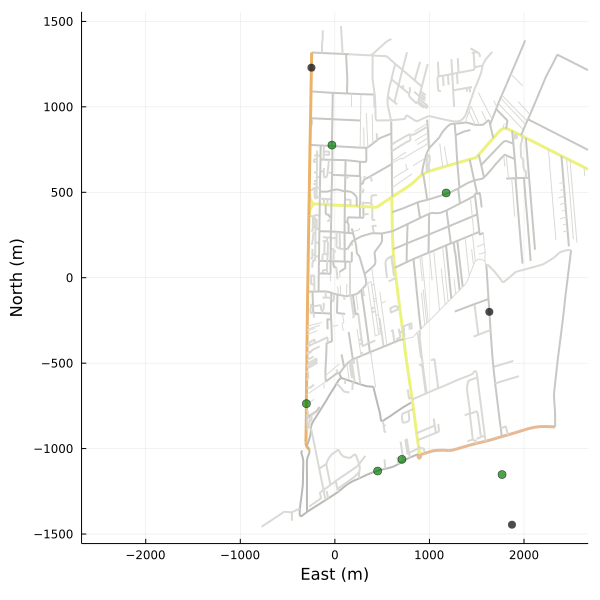

In [20]:
plotmap(m.space.m)
plotagents(m)

In [23]:
values(m.profit)

ValueIterator for a Dict{Int64, Float64} with 9 entries. Values:
  74.09966145833218
  -88.63572916666932
  4.89903645833202
  -2.6227604166666847
  100.68945778161218
  -58.498125000002915
  -86.86126302083687
  109.16891431788409
  122.38226968335141

In [24]:
mean(values(m.profit))

19.402384677259565

In [25]:
median(values(m.profit))

4.89903645833202